In [29]:
from IPython.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [30]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [31]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [32]:
local_planner_color = {'dwa': 'blue', 'arena': 'orange', 'teb': 'green'}
local_planner_symbol = {'dwa': 'o', 'arena': '^', 'teb': 'x'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 200
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2


In [33]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df = pd.read_csv(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results.csv"))
# with open(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    735

## Run Parameters

    amcl_alpha_factor                                                      [1.0]

    available_cpu_threads                                                  [8]

    environment_name                                                       ['7A-2', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['global_planner']

    include_costmap_obstacles                                              [True, nan, False]

    include_dynamic_obstacles                                              [True, nan, False]

    local_planner_node                                                     ['arena', 'dwa', 'teb']

    localization_node                                                      ['amcl']

    min_turning_radius                                                     [0.1, nan, 0.0]

    pedestrian_max_vel                                                     [0.3, 0.6, nan]

    pedestrian_number                                                      [0, 5, 100]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    run_replication_index                                                  [0]

    beta_1                                                                 [0.01, 0.02]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.01, 0.02]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:     0.2653             max:          1             nan:          0

    collision_time                                                         min:        6.4             avg:      86.66             max:        398             nan:        540

    collision_rate_version                                                 [3]

    minimum_clearance                                                      min:          0             avg:     0.2193             max:       2.43             nan:          0

    average_clearance                                                      min:   0.006982             avg:     0.8091             max:       2.72             nan:          0

    median_clearance                                                       min:          0             avg:     0.7266             max:      2.644             nan:          0

    maximum_clearance                                                      min:     0.4512             avg:      1.944             max:      3.312             nan:          0

    clearance_version                                                      [3]

    trajectory_length                                                      min:     0.7721             avg:      25.65             max:      141.7             nan:         68

    trajectory_length_version                                              [1]

    execution_time                                                         min:      3.299             avg:      118.8             max:      571.6             nan:         68

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.6381             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   0.007728             avg:     0.1766             max:      5.811             nan:         68

    odometry_error_alpha_1_std                                             min:   0.003967             avg:     0.9881             max:      24.52             nan:         68

    odometry_error_alpha_2_mean                                            min:   0.001381             avg:      0.348             max:      15.63             nan:         68

    odometry_error_alpha_2_std                                             min:   0.001397             avg:       1.63             max:      38.89             nan:         68

    odometry_error_alpha_3_mean                                            min:    0.01054             avg:    0.03483             max:      1.652             nan:         68

    odometry_error_alpha_3_std                                             min:  0.0002965             avg:    0.07224             max:      2.165             nan:         68

    odometry_error_alpha_4_mean                                            min:   0.001526             avg:    0.07121             max:      1.706             nan:         68

    odometry_error_alpha_4_std                                             min:   0.001252             avg:     0.1533             max:      4.361             nan:         68

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.02147             avg:     0.3704             max:      24.24             nan:         68

    localization_update_absolute_translation_error_std                     min:    0.00368             avg:     0.2673             max:      12.83             nan:         68

    localization_update_absolute_rotation_error_mean                       min:   0.005459             avg:    0.06271             max:      1.595             nan:         68

    localization_update_absolute_rotation_error_std                        min:    0.00116             avg:     0.0877             max:      1.254             nan:         68

    localization_update_relative_translation_error_mean                    min:   0.002462             avg:      0.018             max:     0.2879             nan:         68

    localization_update_relative_translation_error_std                     min:   0.002743             avg:    0.03653             max:      1.421             nan:         68

    localization_update_relative_rotation_error_mean                       min:   0.001973             avg:    0.02121             max:     0.8668             nan:         68

    localization_update_relative_rotation_error_std                        min:   0.001859             avg:    0.06991             max:     0.8327             nan:         68

    localization_update_normalized_relative_translation_error_mean         min:    0.03062             avg:     0.2382             max:      5.315             nan:         68

    localization_update_normalized_relative_translation_error_std          min:    0.01903             avg:     0.6621             max:      28.77             nan:         68

    localization_update_normalized_relative_rotation_error_mean            min:    0.01514             avg:     0.1515             max:      3.082             nan:         68

    localization_update_normalized_relative_rotation_error_std             min:    0.01397             avg:     0.5432             max:      8.477             nan:         68

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.01771             avg:     0.2516             max:      7.426             nan:         68

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:     0.1792             max:      5.139             nan:         68

    absolute_rotation_error                                                min:   0.004861             avg:     0.0324             max:     0.7769             nan:         68

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.05614             max:     0.6655             nan:         68

    collisionless_localization_update_relative_translation_error_mean      min:   0.002462             avg:    0.01655             max:     0.2852             nan:         68

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:    0.02949             max:      1.136             nan:         68

    collisionless_localization_update_relative_rotation_error_mean         min:   0.001553             avg:     0.0135             max:     0.2572             nan:         68

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:     0.0551             max:     0.8327             nan:         68

    normalized_relative_translation_error                                  min:    0.03062             avg:     0.2189             max:      5.315             nan:         69

    collisionless_localization_update_normalized_relative_translation_error_std min:          0             avg:     0.5657             max:      28.77             nan:         69

    normalized_relative_rotation_error                                     min:   0.008587             avg:     0.2125             max:      5.254             nan:         68

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:     0.9227             max:      27.97             nan:         68

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:    0.02738             avg:      0.792             max:      3.172             nan:         68

    localization_update_rate_std                                           min:    0.02983             avg:     0.5998             max:      12.64             nan:         68

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.02192             avg:     0.2371             max:      1.269             nan:         68

    average_rotation_velocity                                              min:    0.02892             avg:     0.2207             max:      9.113             nan:         68

    translation_rotation_product                                           min:   0.006194             avg:    0.06658             max:      11.33             nan:         68

    average_translation_acceleration                                       min:    0.02182             avg:     0.1322             max:      1.895             nan:         68

    average_rotation_acceleration                                          min:    0.03893             avg:     0.2232             max:        1.9             nan:         68

    translation_rotation_acceleration_product                              min:   0.001397             avg:    0.06785             max:      7.807             nan:         68

    average_velocity_atan                                                  min:    0.09708             avg:     0.5075             max:      1.476             nan:         68

    motion_characteristics_version                                         [4]

    move_base_cpu_time                                                     min:       0.89             avg:      37.35             max:      593.1             nan:          0

    simulation_cpu_time                                                    min:      10.79             avg:      392.9             max:       4613             nan:          0

    system_cpu_time                                                        min:       3.91             avg:      122.6             max:       2178             nan:          0

    move_base_max_memory                                                   min:      35.39             avg:      69.95             max:      328.8             nan:          0

    simulation_max_memory                                                  min:      339.5             avg:      518.9             max:       1803             nan:          0

    system_max_memory                                                      min:      132.9             avg:      261.8             max:       1338             nan:          0

    cpu_time_and_max_memory_version                                        [6]

    max_cmd_vel_translation                                                min:   0.003039             avg:     0.2563             max:       0.26             nan:         68

    max_cmd_vel_rotation                                                   min:          0             avg:     0.9283             max:        1.5             nan:         68

    mean_cmd_vel_translation                                               min:    0.00011             avg:     0.2187             max:     0.2599             nan:         68

    mean_cmd_vel_rotation                                                  min:     -1.048             avg:   0.004792             max:     0.9221             nan:         68

    cmd_vel_metrics_version                                                [2]

    normalized_curvature                                                   min:   0.002605             avg:    0.03958             max:     0.5684             nan:         70

    normalized_curvature_version                                           [1]

    pedestrian_encounters                                                  min:          0             avg:      7.158             max:        113             nan:         53

    pedestrian_encounters_version                                          [4]

    average_velocity                                                       min:    0.01627             avg:     0.2195             max:      1.431             nan:         68

    norm_execution_time                                                    min:     0.2649             avg:      1.657             max:      39.49             nan:         85

In [34]:
df.execution_time.agg(['mean', 'count'])

mean    118.799
count   667.000
Name: execution_time, dtype: float64

In [35]:
(df.execution_time.mean() * 1400) / 3600 / 8

5.774963778527403

In [40]:
df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles', 'beta_1']).agg(['mean', 'count'])[['success_rate', 'move_base_cpu_time']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       move_base_cpu_time      
                                                                   mean count               mean count
include_costmap_obstacles include_dynamic_obstacles beta_1                                            
True                      True                      0.010         0.904   146             36.516   146
False                     False                     0.010         0.886   123             13.125   123
                          True                      0.010         0.885    96             10.740    96
True                      True                      0.020         0.605    43             51.694    43
False                     False                     0.020         0.536    28             28.911    28
True                      False                     0.010         0.276    98            112.118    98

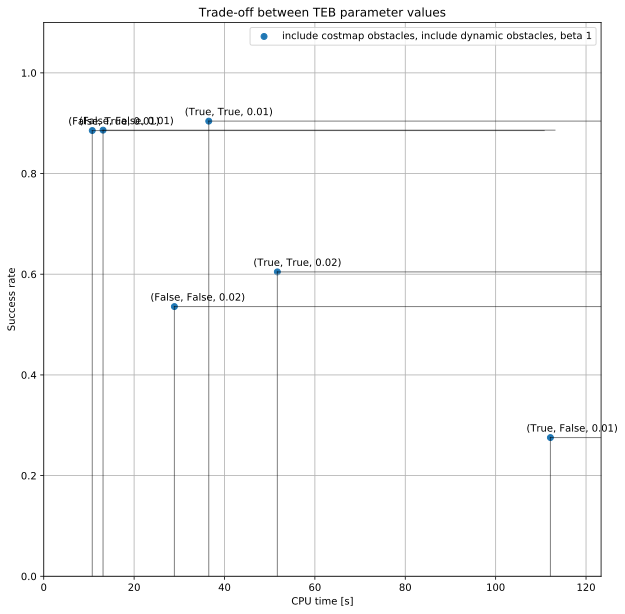

In [39]:
import matplotlib.patches as patches

df_success_cpu_trade_off = df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles', 'beta_1']).agg('mean')[['success_rate', 'move_base_cpu_time']].sort_values(by='success_rate', ascending=False)

fig, ax = plt.subplots()

x = list(df_success_cpu_trade_off.move_base_cpu_time)
y = list(df_success_cpu_trade_off.success_rate)
labels = list(df_success_cpu_trade_off.index)

for x_i, y_i in zip(x, y):
    plt.plot([x_i, x_i+100], [y_i, y_i], color='black', linewidth=1, alpha=0.5)
    plt.plot([x_i, x_i], [-100, y_i], color='black', linewidth=1, alpha=0.5)

for i, label in enumerate(labels):
    ax.annotate(label, xy=(x[i], y[i]), xytext=(-24, 6) , xycoords='data', textcoords='offset points')

ax.scatter(df_success_cpu_trade_off.move_base_cpu_time, df_success_cpu_trade_off.success_rate, label=', '.join(df_success_cpu_trade_off.index.names).replace('_', ' '))
plt.xlabel('CPU time [s]')
plt.ylabel('Success rate')
plt.xlim([0, 1.1*df_success_cpu_trade_off.move_base_cpu_time.max()])
plt.ylim([0, 1.1])
plt.title("Trade-off between TEB parameter values")

plt.legend()
plt.grid()
plt.show()



In [11]:
df.groupby(by=['min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean', 'count'])[['success_rate', 'collision_rate', 'move_base_cpu_time', 'move_base_max_memory']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       collision_rate       move_base_cpu_time       move_base_max_memory      
                                                                               mean count           mean count               mean count                 mean count
min_turning_radius include_costmap_obstacles include_dynamic_obstacles                                                                                            
0.000              True                      True                             0.960    50          0.000    50             27.868    50               69.243    50
0.100              False                     True                             0.922    51          0.000    51             10.936    51               66.193    51
0.000              False                     True                             0.844    45          0.044    45             10.518    45               77.311    45
0.100              False                     False                            0.831    77          0.104    77             15.198    77               67.117    77
0.000              False                     False                            0.811    74          0.149    74             16.942    74               76.567    74
0.100              True                      True                             0.791   139          0.180   139             44.322   139               64.751   139
0.000              True                      False                            0.312    48          0.646    48            114.212    48               75.269    48
0.100              True                      False                            0.240    50          0.680    50            110.108    50               72.506    50

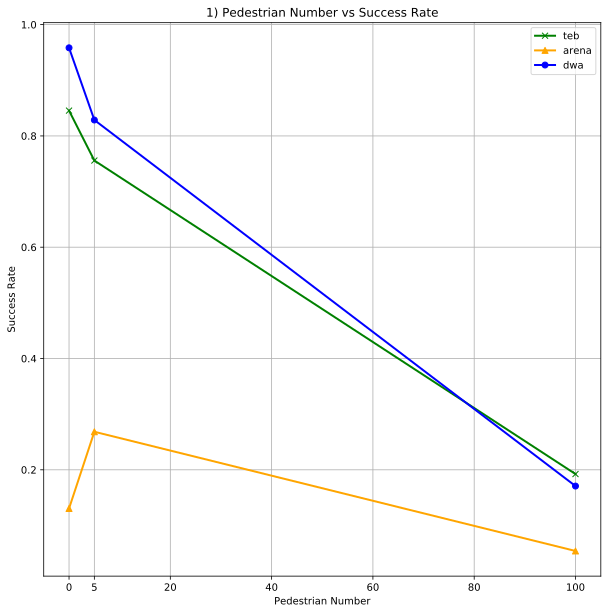

In [42]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_success_rate = df_group.agg('mean').success_rate
    
    plt.plot(df_success_rate.index, df_success_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Success Rate')
plt.title('1) Pedestrian Number vs Success Rate')
plt.grid()
plt.show()

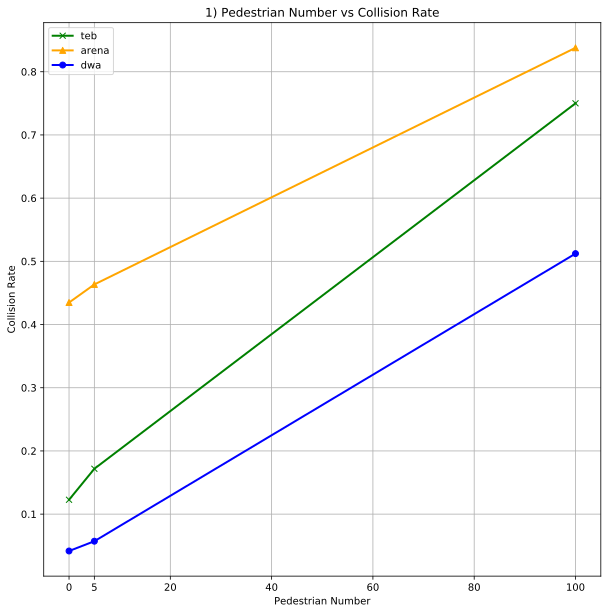

In [12]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_collision_rate = df_group.agg('mean').collision_rate
    
    plt.plot(df_collision_rate.index, df_collision_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Collision Rate')
plt.title('1) Pedestrian Number vs Collision Rate')
plt.grid()
plt.show()

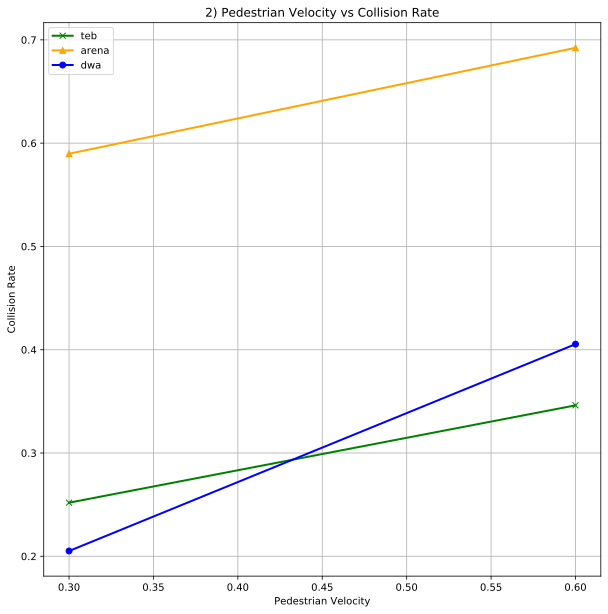

In [13]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_max_vel')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_collision_rate = df_group.agg('mean').collision_rate
    
    plt.plot(df_collision_rate.index, df_collision_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Collision Rate')
plt.title('2) Pedestrian Velocity vs Collision Rate')
plt.grid()
plt.show()

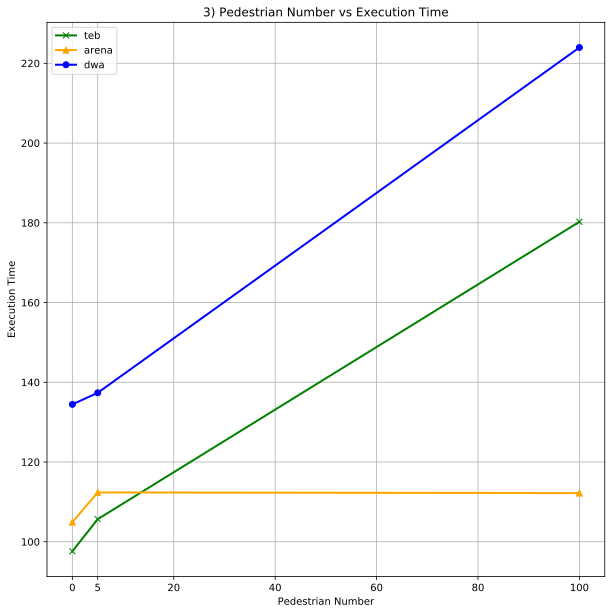

In [14]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').execution_time
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Execution Time')
plt.title('3) Pedestrian Number vs Execution Time')
plt.grid()
plt.show()

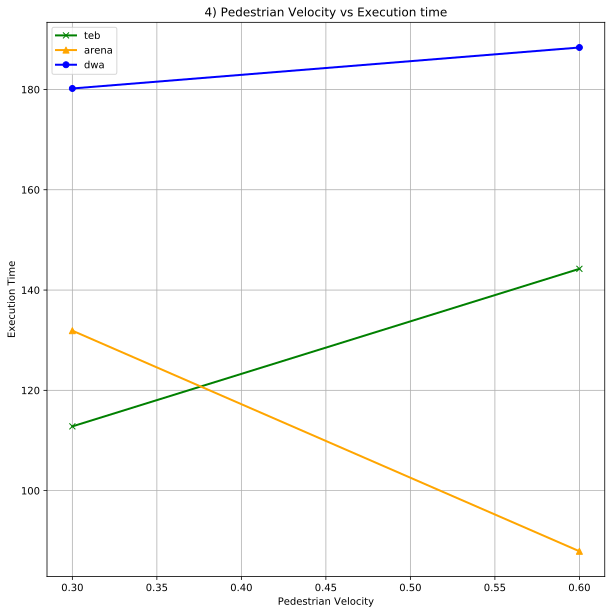

In [15]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_max_vel')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').execution_time
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Execution Time')
plt.title('4) Pedestrian Velocity vs Execution time')
plt.grid()
plt.show()

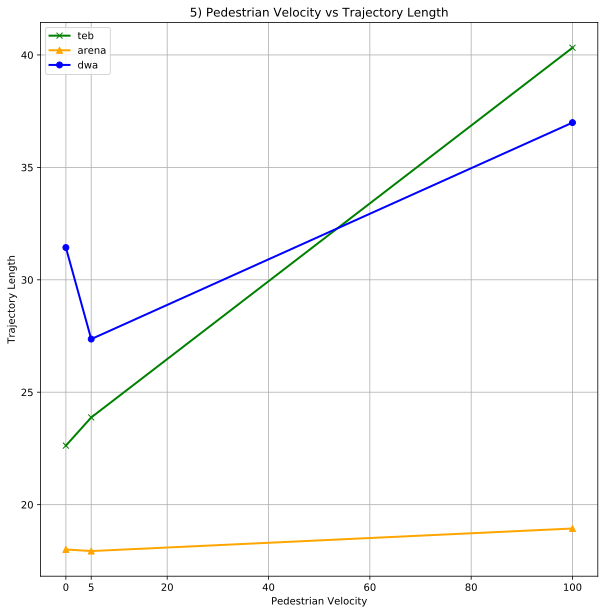

In [16]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').trajectory_length
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Trajectory Length')
plt.title('5) Pedestrian Velocity vs Trajectory Length')
plt.grid()
plt.show()

In [17]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                     0.738   534          0.208   534            0.229   533               1.548   525
            dwa                90                     amcl                     0.590   100          0.240   100            0.189    97               1.705    92
            arena              90                     amcl                     0.158   101          0.594   101            0.169    37               3.260    33

In [18]:
printmd("### Only considering successful runs (sorted by norm execution time)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_execution_time', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm execution time)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                         1   394              0   394            0.251   394               1.097   394
            dwa                90                     amcl                         1    59              0    59            0.215    59               1.440    59
            arena              90                     amcl                         1    16              0    16            0.160    16               4.007    16

In [19]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      dwa                90                     amcl                         0    41          0.585    41            0.148    38               2.179    33
            arena              90                     amcl                         0    85          0.706    85            0.176    21               2.557    17
            teb                90                     amcl                         0   140          0.793   140            0.166   139               2.907   131

## teb only, success rate

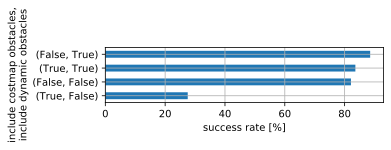

## teb only, collision rate

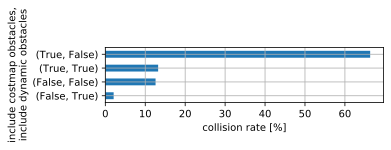

## teb only, cpu usage

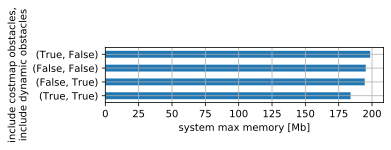

## teb only, cpu time

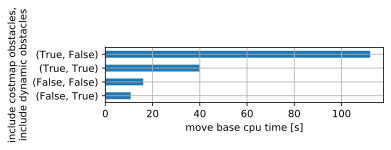

In [26]:
def bar_plot(metric_name, selected_df, y_columns=['local_planner_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
# printmd("## success rate")
# bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
# printmd("## collision_rate")
# bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
# printmd("## average_velocity, only successful runs")
# bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
# printmd("## norm_execution_time, only successful runs")
# bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')
printmd("## teb only, success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], percentage=True, higher_better=True, unit_symbol='%')
printmd("## teb only, collision rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], percentage=True, higher_better=True, unit_symbol='%')
printmd("## teb only, cpu usage")
bar_plot(metric_name='system_max_memory', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], higher_better=True, unit_symbol='Mb')
printmd("## teb only, cpu time")
bar_plot(metric_name='move_base_cpu_time', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], higher_better=True, unit_symbol='s')

In [21]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [ ]:
# 